<a href="https://colab.research.google.com/github/egagli/glacier-velocity-from-sar/blob/main/Velocity_Tracking_Algorithm_Notebook_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VELOCITY TRACKING ALGORITHM**

# **Importing Repo from GIT**

In [5]:

!git clone -b Ahmed https://github.com/egagli/glacier-velocity-from-sar.git


fatal: destination path 'glacier-velocity-from-sar' already exists and is not an empty directory.


## **DENSE OPTICAL FLOW**





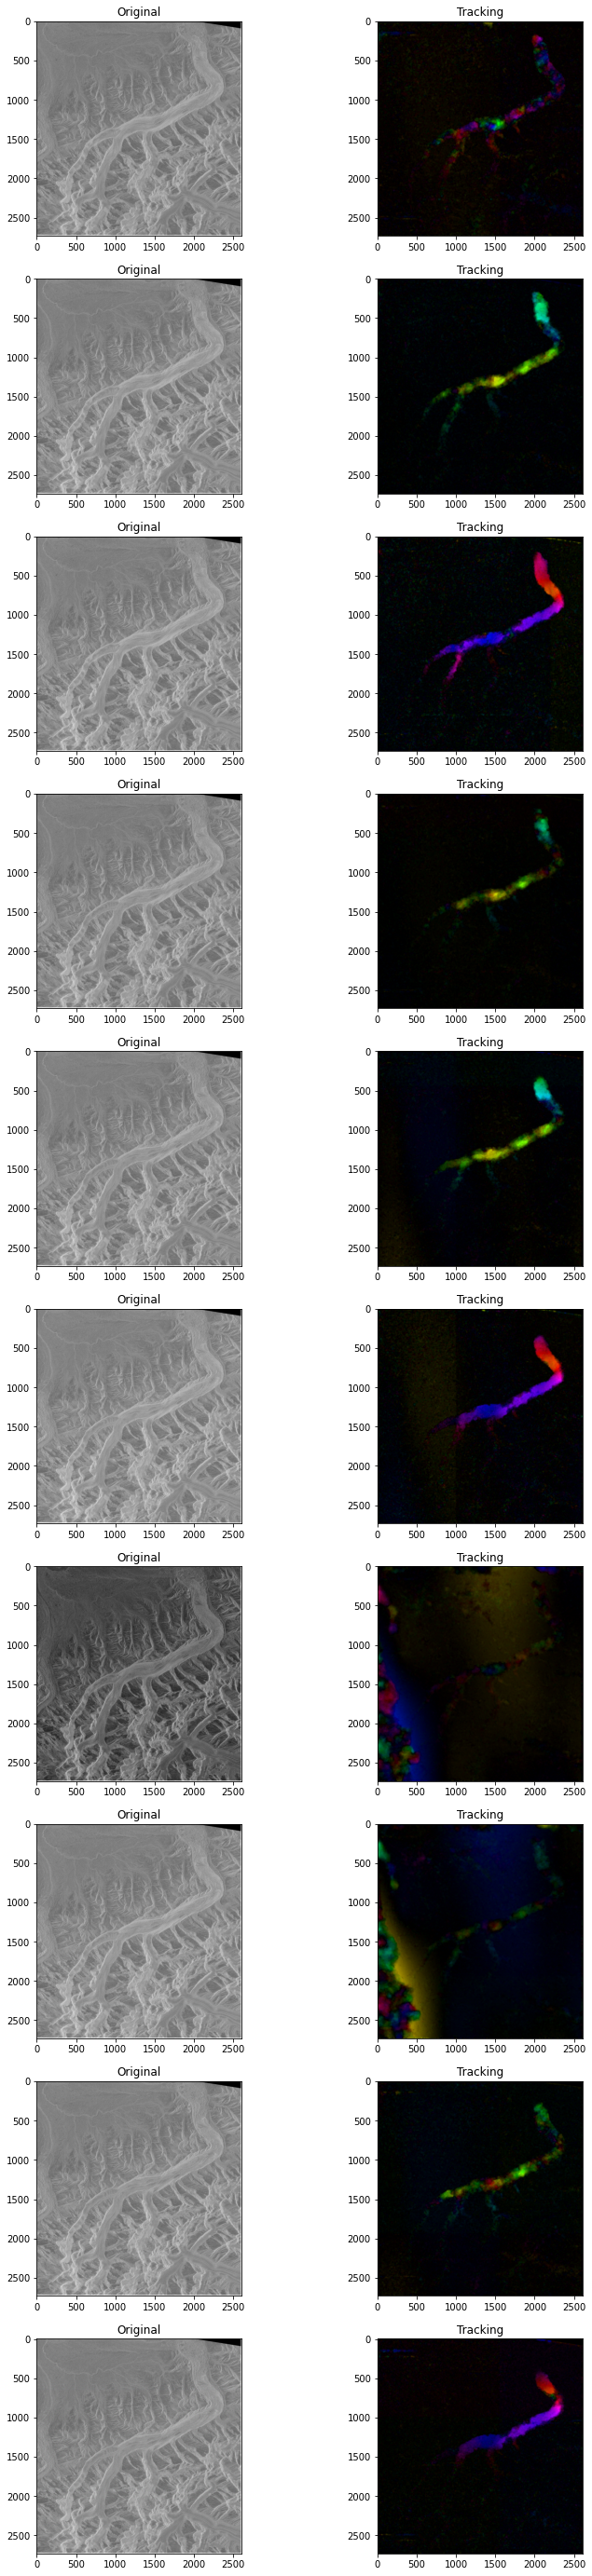

In [3]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


# The video feed is read in as
# a VideoCapture object
cap = cv.imread("/content/glacier-velocity-from-sar/images/0image.png")

import glob
import cv2 as cv
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt

first_frame = cv.imread('/content/glacier-velocity-from-sar/images/0image.png')
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
mask = np.zeros_like(first_frame)
mask[..., 1] = 255

f,ax=plt.subplots(len(glob.glob('/content/glacier-velocity-from-sar/images/*.png')),2,figsize=(12,50))
for i, filename in notebook.tqdm(enumerate(glob.glob('/content/glacier-velocity-from-sar/images/*.png'))):  
    frame = cv.imread(filename)
    
    ax[i,0].imshow(frame)
    ax[i,0].set_title('Original')
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

    mask[..., 0] = angle * 180 / np.pi / 2
      
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
      
    ax[i,1].imshow(rgb)
    ax[i,1].set_title('Tracking')
      
    prev_gray = gray

## **SPARSE OPTICAL FLOW**





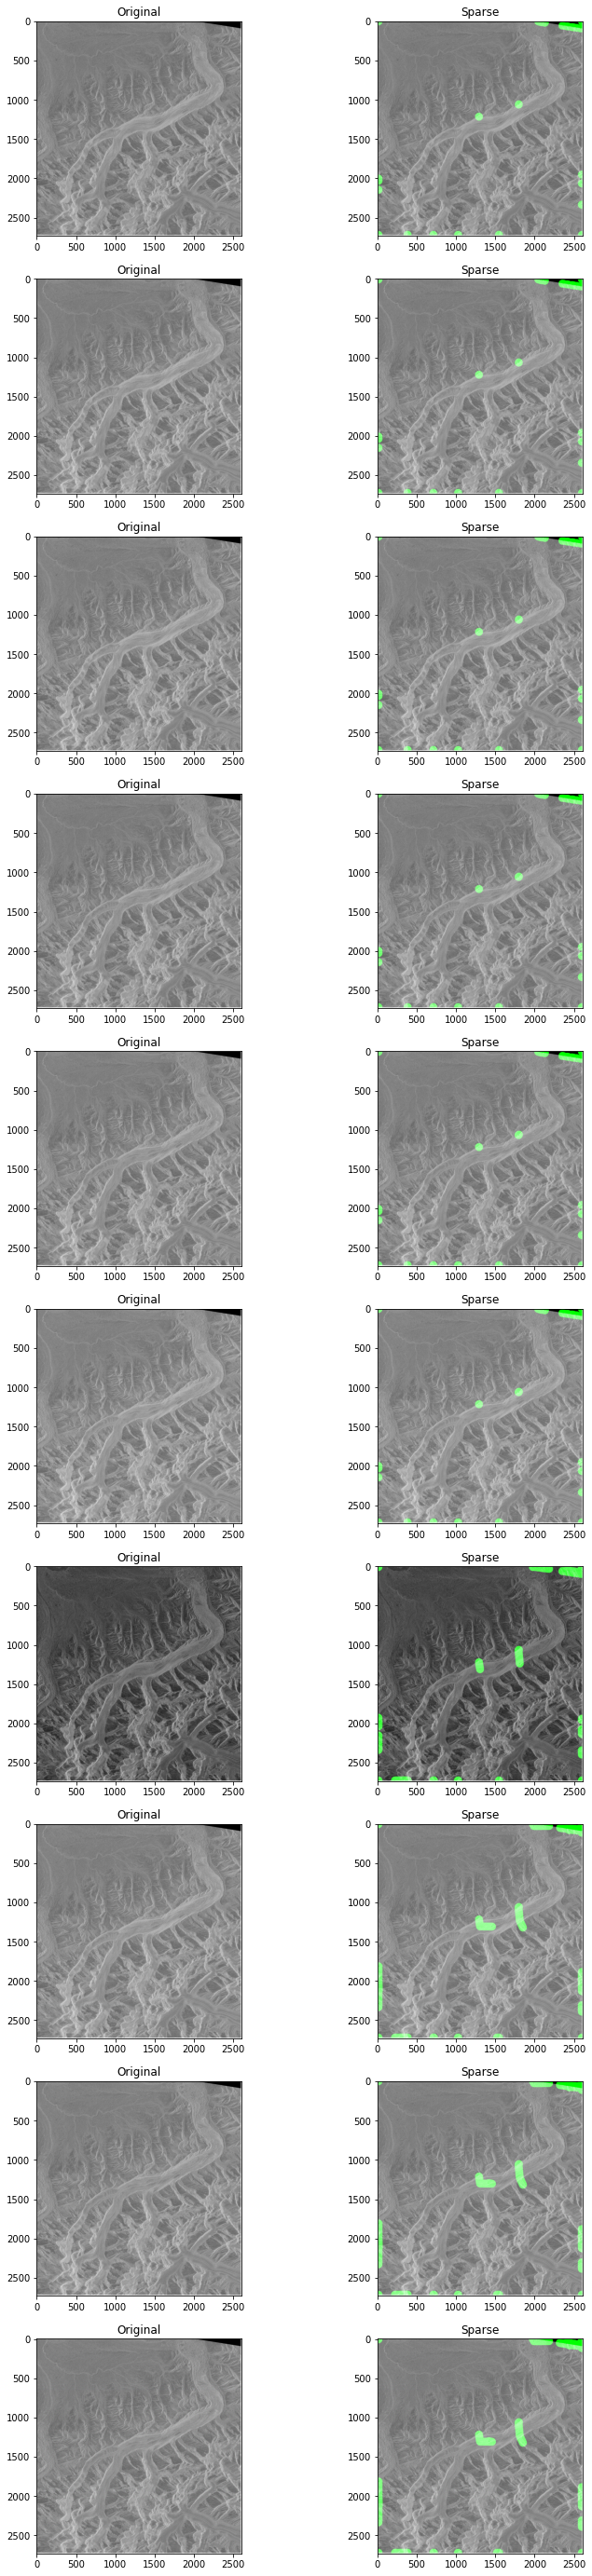

In [4]:
import glob
import warnings
import cv2 as cv
import numpy as np
from tqdm import notebook
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore")

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners = 30, qualityLevel = 0.01, minDistance = 10, blockSize = 10)

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# Variable for color to draw optical flow track
color = (0, 255, 0)

# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
#ret, first_frame = cap.read()
first_frame = cv.imread("/content/glacier-velocity-from-sar/images/0image.png")
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)

# Finds the strongest corners in the first frame by Shi-Tomasi method - we will track the optical flow for these corners
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#goodfeaturestotrack
prev = cv.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)

# Creates an image filled with zero intensities with the same dimensions as the frame - for later drawing purposes
mask = np.zeros_like(first_frame)

f,ax=plt.subplots(len(glob.glob('/content/glacier-velocity-from-sar/images/*.png')),2,figsize=(12,50))
for i, filename in notebook.tqdm(enumerate(glob.glob('/content/glacier-velocity-from-sar/images/*.png'))):  
    frame = cv.imread(filename)
    
    ax[i,0].imshow(frame)
    ax[i,0].set_title('Original')
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    # ret, frame = cap.read()
    
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calculates sparse optical flow by Lucas-Kanade method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowpyrlk
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)
    
    # Selects good feature points for previous position
    good_old = prev[status == 1]
    
    # Selects good feature points for next position
    good_new = next[status == 1]
    
    # Draws the optical flow tracks
    for j, (new, old) in enumerate(zip(good_new, good_old)):
    
        # Returns a contiguous flattened array as (x, y) coordinates for new point
        a, b = new.ravel()
        
        # Returns a contiguous flattened array as (x, y) coordinates for old point
        c, d = old.ravel()
        
        # Draws line between new and old position with green color and 2 thickness
        mask = cv.line(mask, (a, b), (c, d), color, 100)
        
        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv.circle(frame, (a, b), 3, color, -1)
    
    # Overlays the optical flow tracks on the original frame
    output = cv.add(frame, mask)
    
    # Updates previous frame
    prev_gray = gray.copy()
    
    # Updates previous good feature points
    prev = good_new.reshape(-1, 1, 2)
    
    # Opens a new window and displays the output frame
    ax[i,1].imshow(output)
    ax[i,1].set_title('Sparse')